# [**Comparaison entre BIRCH et MiniBatchKMeans**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/2_3_cluster/plot_birch_vs_minibatchkmeans.ipynb)<br/>([*Comparez BIRCH et MiniBatchKMeans*](https://scikit-learn.org/stable/auto_examples/cluster/plot_birch_vs_minibatchkmeans.html))

Cet exemple compare le temps d'exécution de BIRCH (avec et sans l'étape de clustering global) et celui de MiniBatchKMeans sur un jeu de données synthétique contenant 25 000 échantillons et 2 caractéristiques générées à l'aide de `make_blobs`.

`MiniBatchKMeans` et `BIRCH` sont des algorithmes très évolutifs et peuvent s'exécuter efficacement sur des centaines de milliers, voire des millions de points de données. Nous avons choisi de limiter la taille de l'ensemble de données de cet exemple dans le souci de maintenir une utilisation raisonnable de nos ressources d'intégration. Cependant, le lecteur intéressé peut modifier ce script pour le ré-exécuter avec une valeur plus grande pour `n_samples`.

Si `n_clusters` est défini sur `None`, les données sont réduites de 25 000 échantillons à un ensemble de 158 grappes. On peut voir cela comme une étape de prétraitement avant l'étape finale de regroupement (global) qui réduit encore ces 158 grappes à 100 grappes.

BIRCH without global clustering as the final step took 0.93 seconds
n_clusters : 158
BIRCH with global clustering as the final step took 0.68 seconds
n_clusters : 100
Time taken to run MiniBatchKMeans 0.59 seconds


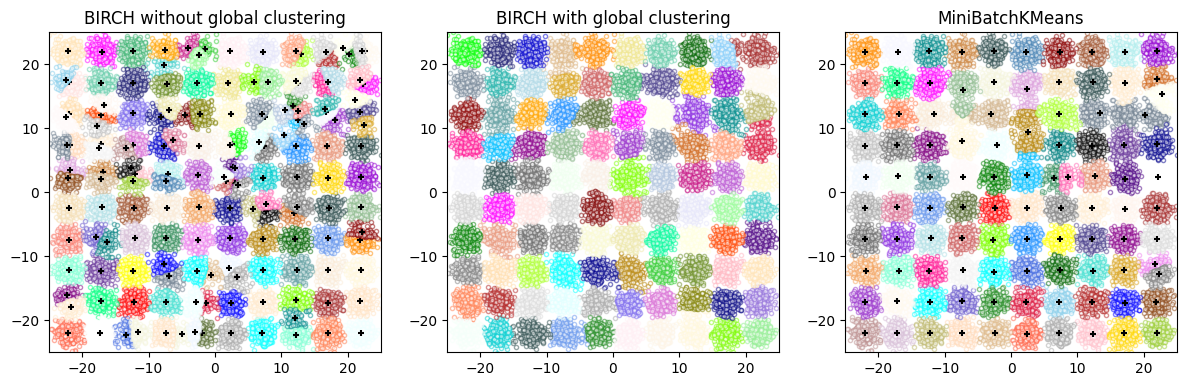

In [1]:
# Authors: Manoj Kumar <manojkumarsivaraj334@gmail.com
#          Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
# License: BSD 3 clause

from joblib import cpu_count
from itertools import cycle
from time import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.datasets import make_blobs


# Generate centers for the blobs so that it forms a 10 X 10 grid.
xx = np.linspace(-22, 22, 10)
yy = np.linspace(-22, 22, 10)
xx, yy = np.meshgrid(xx, yy)
n_centers = np.hstack((np.ravel(xx)[:, np.newaxis], np.ravel(yy)[:, np.newaxis]))

# Generate blobs to do a comparison between MiniBatchKMeans and BIRCH.
X, y = make_blobs(n_samples=25000, centers=n_centers, random_state=0)

# Use all colors that matplotlib provides by default.
colors_ = cycle(colors.cnames.keys())

fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.1, top=0.9)

# Compute clustering with BIRCH with and without the final clustering step
# and plot.
birch_models = [
    Birch(threshold=1.7, n_clusters=None),
    Birch(threshold=1.7, n_clusters=100),
]
final_step = ["without global clustering", "with global clustering"]

for ind, (birch_model, info) in enumerate(zip(birch_models, final_step)):
    t = time()
    birch_model.fit(X)
    print("BIRCH %s as the final step took %0.2f seconds" % (info, (time() - t)))

    # Plot result
    labels = birch_model.labels_
    centroids = birch_model.subcluster_centers_
    n_clusters = np.unique(labels).size
    print("n_clusters : %d" % n_clusters)

    ax = fig.add_subplot(1, 3, ind + 1)
    for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
        mask = labels == k
        ax.scatter(X[mask, 0], X[mask, 1], c="w", edgecolor=col, marker=".", alpha=0.5)
        if birch_model.n_clusters is None:
            ax.scatter(this_centroid[0], this_centroid[1], marker="+", c="k", s=25)
    ax.set_ylim([-25, 25])
    ax.set_xlim([-25, 25])
    ax.set_autoscaley_on(False)
    ax.set_title(f"BIRCH {info}")

# Compute clustering with MiniBatchKMeans.
mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=100,
    batch_size=256 * cpu_count(),
    n_init=10,
    max_no_improvement=10,
    verbose=0,
    random_state=0,
)
t0 = time()
mbk.fit(X)
t_mini_batch = time() - t0
print("Time taken to run MiniBatchKMeans %0.2f seconds" % t_mini_batch)
mbk_means_labels_unique = np.unique(mbk.labels_)

ax = fig.add_subplot(1, 3, 3)
for this_centroid, k, col in zip(mbk.cluster_centers_, range(n_clusters), colors_):
    mask = mbk.labels_ == k
    ax.scatter(X[mask, 0], X[mask, 1], marker=".", c="w", edgecolor=col, alpha=0.5)
    ax.scatter(this_centroid[0], this_centroid[1], marker="+", c="k", s=25)
ax.set_xlim([-25, 25])
ax.set_ylim([-25, 25])
ax.set_title("MiniBatchKMeans")
ax.set_autoscaley_on(False)
plt.show()